## Instance Segmentation of Agricultural Fields Satellite Imagery

The focus of this work is to explore the application of current advanced instance segmentation and edge detection techniques to satellite images of agricultural regions, in order to delineate areas of different crop species, assess field boundaries, and identify ownership distinctions.

### Computer vision tasks
At first, let's describe the main computer vision tasks (on static, perhaps multi-layer images) we can be dealing with:
- [Semantic segmentation](https://paperswithcode.com/task/semantic-segmentation) - the goal is to **categorize** pixels of the image into a class (e.g. person, animal, building, background).
- [Instance segmentation](https://paperswithcode.com/task/instance-segmentation) - the goal is to **assign** pixels of the image to a specific object instances (e.g. particular persons, animals, cars).
- [Object detection](https://paperswithcode.com/task/object-detection) - the goal is to detect and locate objects of interest in an image. Here, the one-to-one correspondence between pixels and classes is lost (either because we allow instances overlapping in a single image or we just want to detect the presence of an object or draw its boundries, not concerning the specific pixels that consist it)

![Computer vision tasks](visualization/computer-vision-tasks.png)

Since on flat (pun intended) surface of the earth, overlapping of agricultural areas do not occur, the closest matching computer vision objective to ours is **instance segmentation**.

The desired properties of the separated fields/generated edges would be:
- mostly regular shape of the field instance (i.e. convex, parallelogram, grid-like),
- the closedness of the areas between edges (no edge gaps, continuity),
- adherence to local (in the context of image) rules for the design of parcels (e.g. a sequence of rectangular shape plots, region of circular farms etc.)


## MaskRCNN (instance segmentation)

Our first approach would be with a well-established, providing satisfactory results (~State of the art) with many instance segmentation tasks model - **MaskRCNN**. Below a schematic view of how it works.
![MaskRCNN architecture](visualization/maskrcnn-architecture.png)
As it is a Region-Based Convolutional Neural Network (R-CNN), it extracts region proposals (ROI - Regions of Interest) from the input image and the evaluates a "normal" CNN network independently for all ROI, classifying them.
MaskRCNN improves on the design of FasterRCNN, a network which uses a Region Proposal Network to do this task, by adding a branch that calculates an object mask for the Region of Interest (in addition to classification and a bounding-box), thus requiring the extraction of a much finer spatial layout of an object.

![MaskRCNN architecture 2](visualization/maskrcnn-architecture.webp)

### Dataset choice

- For the satellite image background, the Sentinel2 dataset was chosen. It is a free and open-source database of 10m pixel resolution, 13-channel database of satellite imagery, updated every 2-4 weeks for Europe region. The problems in the dataset are small resolution and most of the photos have substatntial cloud cover. Rejected alternatives was due to their non-availability for easy data analysis. Example fragment from this dataset (used later for training):

![Denmark in Sentinel image](visualization/dania.png)

- For the plots overlay, we choose Denmark's Government data for agricultural fields. It is roughly 600 thousands vector plots with their designation, collected from applications for subsidies. Rejected alternatives were Polish Government dataset (rejected for mainly ownership-oriented character of separation, which collided with our plant species segmentation goal) and Russian Government dataset (rejected for huge dataset inconsistencies). Example fragment of the combined dataset used for training the MaskRCNN network looks following:

![Danish plots](visualization/dzialki-dania.jpg)

### Training

The model training regime:
- the backbone constitutes of ResNet-101 network pretrained on ImageNet,
- trained on above dataset for 8 epochs (around that time the valuation accuracy started to wobble),
- dataset was normalized (every channel had mean equal to zero and standard deviation of 1),
- optimizer used was Adam, with following learning rates:
    - first 4 epochs: 0.001
    - next 2 epochs: 0.0001
    - last 2 epochs: 0.00001

### Results

The results were unsatisfactory, due to:
- low certainty of model predictions
- overlapping instances of plots
- roundiness of edges of rectangular-shaped plots

Below we can see results for a box-score (a measure of model certainity that the instance is an agricultural field) threshold of 60%.

![MaskRCNN ground truth 1](visualization/maskrcnn-truth-1.png)
![MaskRCNN results 1](visualization/maskrcnn-after-1.png)
![MaskRCNN ground truth 2](visualization/maskrcnn-truth-2.png)
![MaskRCNN results 2](visualization/maskrcnn-after-2.png)



### Edge detection approach

Interestingly, since we most often are dealing with full image division (every pixel is assigned to some area), we can approach this problem also as an **edge detection task**. In this case, the edge detection output (pixel being an edge binary classification) needs to be converted to an image of clearly separated, continuous areas between the edges.

- [Edge detection](https://paperswithcode.com/task/edge-detection) - the goal is a binary classification of the image pixels into being an edge or not.

This idea led us to experiment with one of the current go-to solutions for edge detection - DexiNed 

### DexiNed

The DexiNed network is the current [state of the art](https://paperswithcode.com/paper/dense-extreme-inception-network-for-edge) solution for edge detection on various image datasets.

Its architecture consists of six blocks acting as an encoders. Each block is a collection of smaller sub-blocks with a group of convolutional layers. Skip-connections couple the blocks as well as their sub-blocks (depicted in light gray and blue rectangular shapes on the figure below). The feature-maps generated at each of the blocks are fed to a separate USNet to create intermediate edge-maps. These intermediate edge-maps are concatenated to form a stack of learned filters. At the very end of the network, these features are fused to generate a single edge-map. 

![DexiNed architecture](visualization/dexined-architecture.png)

The datasets it was trained and tested on are the following:

- [BIPED](https://paperswithcode.com/dataset/biped) (Barcelona Images for Perceptual Edge Detection) - 250 expert annotated images of 720p resolution, depicting various outdoor sceneries and objects

![BIPED](visualization/BIPED.png)

- [MDBD](https://paperswithcode.com/dataset/mdbd) (Multicue Dataset for Edge Detection) - 100 scenes, 10-frame 720p color multi-cue video dataset composed of short binocular video sequences of natural scenes filmed in a variety of places (from university campuses to street scenes and parks) and seasons to minimize possible biases, expert annotated

![MDBD](visualization/MDBD.png)

- [UDED](https://paperswithcode.com/dataset/uded) (Unified Dataset for Edge Detection) - collection of 1, 2, or 3 images from multiple edge detection datasets: BIPED, BSDS500, BSDS300, DIV2K, WIRE-FRAME, CID, CITYSCAPES, ADE20K, MDBD, NYUD, THANGKA, PASCAL-Context, SET14, URBAN10, and the camera-man image.

It was trained on, and is suited towards various scenery images. We will check its performance on satellite imagery of agricultural fields before and after finetuning on the domain-specific data.

In [6]:
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import torch
import numpy as np

from DexiNed.model import DexiNed
from DexiNed.utils import visualisePolygons
from DexiNed.process_image import tiffToVector

In [7]:
MEAN_PATH = "./DexiNed/mean.pt"
VIS_SOURCE = "./visualization"
BASELINE_MODEL_PATH = "./DexiNed/baseline-model.pt"
FINETUNED_MODEL_PATH = "./DexiNed/finetuned-model.pt"

assert os.path.exists(MEAN_PATH), "No mean and std file (from the model's training dataset) found."
MEAN, _ = torch.load(MEAN_PATH)

DEVICE = torch.device('cpu' if torch.cuda.device_count() == 0 else 'cuda')

In [8]:
def visualize_results(model):
    image_scale = 4
    vis_data = [os.path.join(VIS_SOURCE, _) for _ in os.listdir(VIS_SOURCE) if _.startswith("input")]
    fig, axs = plt.subplots(3, len(vis_data),
                            figsize=(image_scale*len(vis_data), image_scale*3),
                            gridspec_kw = {'wspace':0, 'hspace':0})
    [ax.set_axis_off() for ax in axs.ravel()]

    progress = tqdm(range(len(vis_data)))
    progress.set_description("Generating visualizations")
    for i in progress:
        img = cv2.cvtColor(cv2.imread(vis_data[i]), cv2.COLOR_BGR2RGB)
        polygons = tiffToVector(vis_data[i], 70, 220, model, MEAN, DEVICE, geo_reference=False)
        res = visualisePolygons(polygons, img)

        axs[0][i].imshow(img)
        axs[1][i].imshow(res)
        colored = img.copy()
        for p in polygons:
            new_color = tuple([int(_) for _ in np.random.randint(256, size=3)])
            cv2.fillPoly(colored, [np.array(_, dtype='int32') for _ in p[0]['coordinates']], new_color)
        axs[2][i].imshow(colored)
    plt.show()

model = DexiNed().to(DEVICE)

### Baseline model

Generating visualizations: 100%|███████████████████████████| 3/3 [00:54<00:00, 18.16s/it]


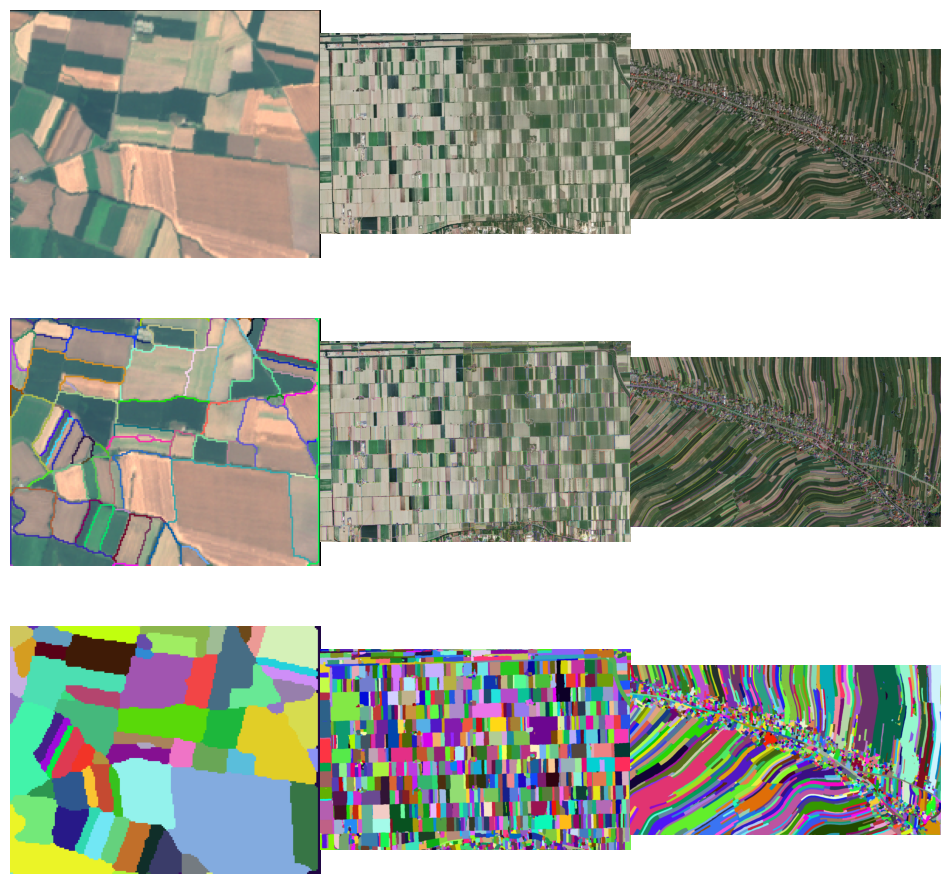

In [9]:
model.load_state_dict(torch.load(BASELINE_MODEL_PATH, map_location=DEVICE))
visualize_results(model)

As we can see, the model correctly recognizes most of the edges between fields. There are however some problems with the results:
- Model tends to incorporate similar small areas into bigger adjacent one (perhaps it is desired in normal edge detection task)
- In situations when fields are not clearly visually separated (either by difference in color or by some road, footpath etc), often the desired solution would be to separate them "just in case" by rules from the neighbourhood. For example, when the model gets a sequence of same-shape plots and two adjacent ones are not clearly separated, it should split.

In summary, this particular segmentation task (in the context of utilizing DexiNed - edge detection task) has its peculiarities that need to be trained for. We will try to achieve this by finetuning the model on a prepared dataset.

### Finetuned model

The (small) dataset for this task was creaated by hand, using a prepared tool for annotating the satellite images for edges.
In the end, a set of 17 400x400 pixel annotated images from Polish Opole Voivodeship was established. The fine-tuning consisted of 10 epochs on this dataset. 

Generating visualizations: 100%|███████████████████████████| 3/3 [01:26<00:00, 28.90s/it]


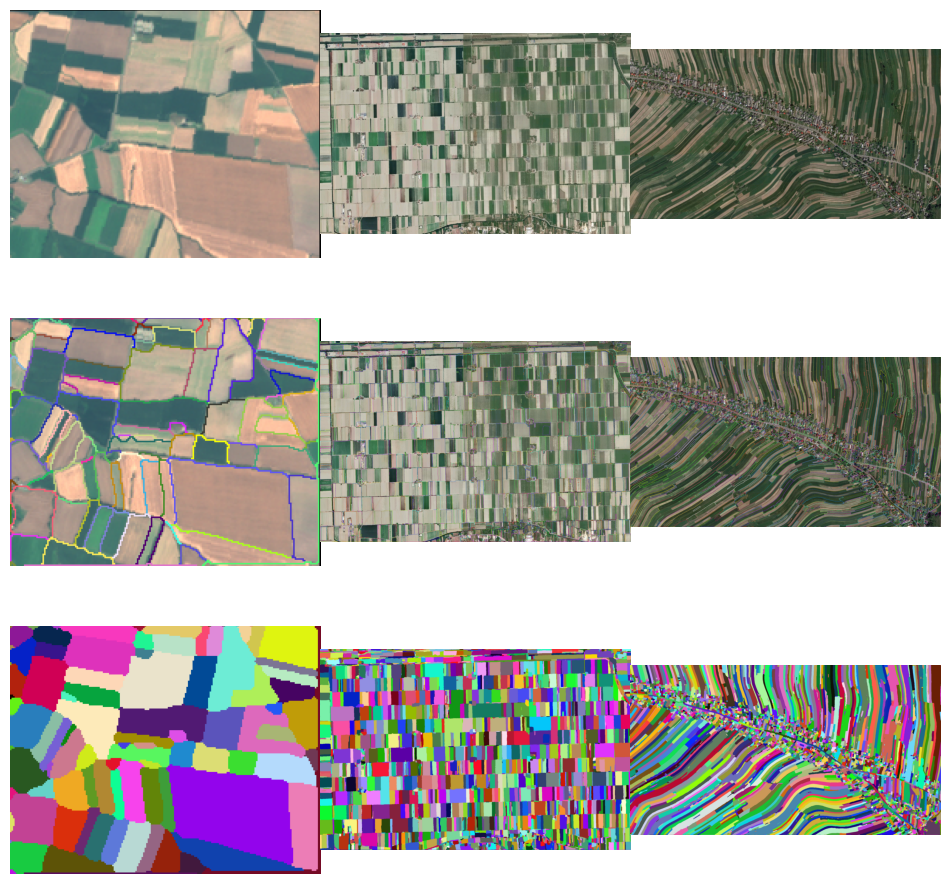

In [10]:
model.load_state_dict(torch.load(FINETUNED_MODEL_PATH, map_location=DEVICE))
visualize_results(model)

In the end, the model produces more instances and they are more diverse. 

## Other results and solutions

Since we established a method to use edge detection algorithms for this task, it was tempting to utilize the faster, more straight-forward and algorithmic methods of detecting an edge among pixels (with an assumption that edge as a micro-scale feature should not be that hard to pinpoint). Below we demonstrated the results of applying some of the algorithms to satellite imagery of agricultural areas:

### [Canny edge detector algorithm](https://en.wikipedia.org/wiki/Canny_edge_detector)
![Canny edge detector input image](visualization/canny-before.png)
![Canny edge detector result](visualization/canny-edges.png)
![Canny edge detector overlay](visualization/canny-overlay.png)

### Felzenszwalb's Algorithm
![Felzenszwalb's algorithm input image](visualization/felzenszwalb-before.jpg)
![Felzenszwalb's algorithm overlay](visualization/felzenszwalb-after.png)

### Orfeo Toolbox

There exist an entire open-source software library coupled with a set of tools called [Orfeo Toolbox](https://www.orfeo-toolbox.org/), targeted for processing images from Earth observation satellites, and initiated by the French space agency in 2006.

![Orfeo-toolbox GUI](visualization/orfeo-gui.jpg)

One of its funcionalities is the segmentation of input satellite image based on [various](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) conventional algorithms (e.g. clustering algorithms) like Meanshift or Watershed. Below are the example results of using the Meanshift method on a large area of agricultural land mixed with small settlements.

![Original image](visualization/orfeo-before.jpg)
![Segmentated image](visualization/orfeo-after.png)